In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *

from tensorflow.keras.models import Model
import random

In [2]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553467096/553467096 [==============================] - 5s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
def layer_name(model):
  layers= ['Input', 'Conv1-1', 'Conv1-2', 'Pooling1',
                  'Conv2-1','Conv2-2','Pooling2',
                  'Conv3-1','Conv3-2','Conv3-3','Pooling3',
                  'Conv4-1','Conv4-2','Conv4-3','Pooling4',
                  'Conv5-1','Conv5-2','Conv5-3','Pooling5',
                  'Dense1','Dense2','Dense3',
                  'Output']
  for i, layers in enumerate(layers):
    model.layers[i]._name = layers
  return model

In [5]:
model = layer_name(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv1-1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1-2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 Pooling1 (MaxPooling2D)     (None, 112, 112, 64)      0         
                                                                 
 Conv2-1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 Conv2-2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 Pooling2 (MaxPooling2D)     (None, 56, 56, 128)       0     

In [6]:
from fastai.vision.all import *
from tqdm.auto import tqdm, trange
from PIL import Image
import os


In [7]:
path = untar_data(URLs.IMAGENETTE_160)

In [8]:
#train
data_label = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03445777']
data = 'train'
y = []
x = []
for i in tqdm(range(len(data_label))):
  imgs = [f for f in os.listdir(f'{path}/{data}/{data_label[i]}/') if f.endswith('.JPEG') or f.endswith('.jpeg') or f.endswith('.jpg')]
  for j in imgs:
    temp = Image.open(f'{path}/{data}/{data_label[i]}/{j}')
    if(temp.mode == 'RGB'):
      temp = temp.resize((224, 224), Image.ANTIALIAS)
      temp = np.array(temp)
      x.append(temp)
      y.append(i)
  

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
train_x = np.array(x)
train_y = np.array(y)
np.save('imagenette_x.npy', train_x)
np.save('imagenette_y.npy', train_y)

In [10]:
train_x.shape, train_y.shape

((4663, 224, 224, 3), (4663,))

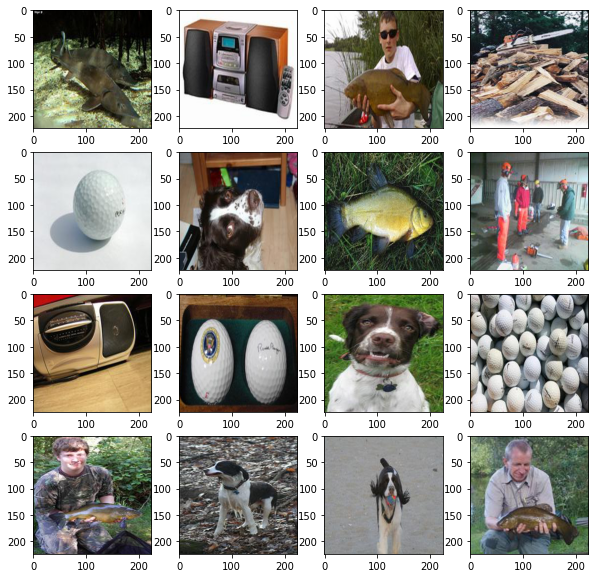

In [11]:
display = random.sample(range(4000),16)
fig = plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_x[display[i]])
plt.show()

In [12]:
#Validate
data_label = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03445777']
data = 'val'
y = []
x = []
for i in tqdm(range(len(data_label))):
  imgs = [f for f in os.listdir(f'{path}/{data}/{data_label[i]}/') if f.endswith('.JPEG') or f.endswith('.jpeg') or f.endswith('.jpg')]
  for j in imgs:
    temp = Image.open(f'{path}/{data}/{data_label[i]}/{j}')
    if(temp.mode == 'RGB'):
      temp = temp.resize((224, 224), Image.ANTIALIAS)
      temp = np.array(temp)
      x.append(temp)
      y.append(i)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
test_x = np.array(x)
test_y = np.array(y)
np.save('imagenette_x_test.npy', test_x)
np.save('imagenette_y_test.npy', test_y)
test_x.shape, test_y.shape

((1907, 224, 224, 3), (1907,))

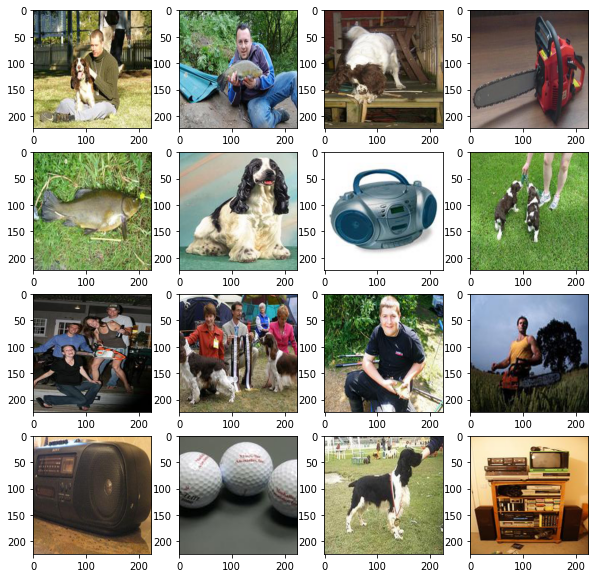

In [14]:
display = random.sample(range(4000),16)
fig = plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_x[display[i]])
plt.show()

In [22]:
def SENet(input):
    s = input.shape[3]
    x1 = GlobalAveragePooling2D(name='SENet_pool')(input)
    x1 = Dense(s // 16, activation='relu',name='SENet_Dense_1')(x1)
    x1 = Dense(s, activation='sigmoid',name='SENet_Dense_2')(x1)
    x = Multiply(name='SENet_multiply')([input, x1])
    return x

In [18]:
model.trainable = False

In [19]:
for layer in model.layers:
    print(layer.name,":",layer.trainable)

Input : False
Conv1-1 : False
Conv1-2 : False
Pooling1 : False
Conv2-1 : False
Conv2-2 : False
Pooling2 : False
Conv3-1 : False
Conv3-2 : False
Conv3-3 : False
Pooling3 : False
Conv4-1 : False
Conv4-2 : False
Conv4-3 : False
Pooling4 : False
Conv5-1 : False
Conv5-2 : False
Conv5-3 : False
Pooling5 : False
Dense1 : False
Dense2 : False
Dense3 : False
Output : False


In [23]:
#between  input  and  conv  1-1

def get_senet_1():
    model.trainable = False
    
    input = Input((224, 224, 3))

    #SENet implementaion 
    x = SENet(input)

    x = model.get_layer(index=1)(x)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)
    
    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='prediction')(x)

    return Model(input, x, name='model1')

In [25]:
#between  pooling  and  conv  2-1

def get_senet_2():
    model.trainable = False
    
    input = Input((224, 224, 3))
    
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    #SENet implementaion 
    x = SENet(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)
    
    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='prediction')(x)

    return Model(input, x, name='model2')

In [26]:
#between  pooling  and  conv  3-1

def get_senet_3():
    model.trainable = False
    
    input = Input((224, 224, 3))
    
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    #SENet implementaion 
    x = SENet(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)
    
    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='Prediction')(x)

    return Model(input, x, name='model3')

In [27]:
#between  pooling  and  conv  4-1

def get_senet_4():
    model.trainable = False
    
    input = Input((224, 224, 3))
    
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)

    #SENet implementaion 
    x = SENet(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)
    
    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='Prediction')(x)

    return Model(input, x, name='model4')

In [28]:
#between  pooling  and  conv  5-1

def get_senet_5():
    model.trainable = False
    
    input = Input((224, 224, 3))
    
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)

    #SENet implementaion 
    x = SENet(x)

    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='Prediction')(x)

    return Model(input, x, name='model5')

In [29]:
#between  pooling  and  dense

def get_senet_6():
    model.trainable = False
    
    input = Input((224, 224, 3))
    
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)

    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)

    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)

    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)

    #SENet implementaion 
    x = SENet(x)

    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='Prediction')(x)

    return Model(input, x, name='model6')

In [30]:
model1 = get_senet_1()      # Between input and Conv 1-1 

model2 = get_senet_2()      # Between Pooling and conv 2-1

model3 = get_senet_3()      # Between Pooling and Conv 3-1

model4 = get_senet_4()      # Between Pooling and Conv 4-1

model5 = get_senet_5()      # Between Pooling and Conv 5-1

model6 = get_senet_6()      # Between last pooling and dense
models = [model1, model2, model3, model4, model5, model6]

In [31]:
for model in models:
  model.summary()

Model: "model1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 SENet_pool (GlobalAveragePooli  (None, 3)           0           ['input_4[0][0]']                
 ng2D)                                                                                            
                                                                                                  
 SENet_Dense_1 (Dense)          (None, 0)            0           ['SENet_pool[0][0]']             
                                                                                             

In [32]:
def basic_model():
    model.trainable = False
    input = Input((224, 224, 3))
    x = model.get_layer(index=1)(input)
    x = model.get_layer(index=2)(x)
    x = model.get_layer(index=3)(x)
    x = model.get_layer(index=4)(x)
    x = model.get_layer(index=5)(x)
    x = model.get_layer(index=6)(x)
    x = model.get_layer(index=7)(x)
    x = model.get_layer(index=8)(x)
    x = model.get_layer(index=9)(x)
    x = model.get_layer(index=10)(x)
    x = model.get_layer(index=11)(x)
    x = model.get_layer(index=12)(x)
    x = model.get_layer(index=13)(x)
    x = model.get_layer(index=14)(x)
    x = model.get_layer(index=15)(x)
    x = model.get_layer(index=16)(x)
    x = model.get_layer(index=17)(x)
    x = model.get_layer(index=18)(x)
    x = model.get_layer(index=19)(x)
    x = model.get_layer(index=20)(x)
    x = model.get_layer(index=21)(x)
    x = Dense(5, activation='softmax', name='Prediction')(x)

    return Model(input, x, name='basic_model')

In [33]:
model_0 = basic_model()
model_0.summary()

Model: "basic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 Conv1-1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1-2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 Pooling1 (MaxPooling2D)     (None, 112, 112, 64)      0         
                                                                 
 Conv2-1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 Conv2-2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 Pooling2 (MaxPooling2D)     (None, 56, 56, 128)       

In [35]:
def comparison(model, model_name):
    optimize= tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimize, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=8,
    validation_data=(test_x, test_y),
    validation_batch_size=64
    )
    model.save(f'assignment3_trained_/{model_name}.h5')
    return model,history

In [36]:
model_0,history_0 = comparison(model_0, 'basic_model')

Epoch 1/8
73/73 [==============================] - 49s 514ms/step - loss: 1.7038 - accuracy: 0.2305 - val_loss: 1.6086 - val_accuracy: 0.2260
Epoch 2/8
73/73 [==============================] - 30s 407ms/step - loss: 1.5393 - accuracy: 0.3140 - val_loss: 1.4640 - val_accuracy: 0.4106
Epoch 3/8
73/73 [==============================] - 30s 412ms/step - loss: 1.4031 - accuracy: 0.4658 - val_loss: 1.3469 - val_accuracy: 0.5480
Epoch 4/8
73/73 [==============================] - 30s 416ms/step - loss: 1.2872 - accuracy: 0.5897 - val_loss: 1.2424 - val_accuracy: 0.6261
Epoch 5/8
73/73 [==============================] - 30s 417ms/step - loss: 1.1887 - accuracy: 0.6670 - val_loss: 1.1604 - val_accuracy: 0.6696
Epoch 6/8
73/73 [==============================] - 30s 419ms/step - loss: 1.1064 - accuracy: 0.7053 - val_loss: 1.0861 - val_accuracy: 0.6922
Epoch 7/8
73/73 [==============================] - 31s 422ms/step - loss: 1.0368 - accuracy: 0.7266 - val_loss: 1.0252 - val_accuracy: 0.7058
Epoch 

In [38]:
model1,history_1 = comparison(model1, 'model1')

Epoch 1/8
73/73 [==============================] - 63s 791ms/step - loss: 0.7042 - accuracy: 0.7517 - val_loss: 0.2710 - val_accuracy: 0.9098
Epoch 2/8
73/73 [==============================] - 53s 734ms/step - loss: 0.2039 - accuracy: 0.9427 - val_loss: 0.1834 - val_accuracy: 0.9407
Epoch 3/8
73/73 [==============================] - 53s 734ms/step - loss: 0.1497 - accuracy: 0.9556 - val_loss: 0.1570 - val_accuracy: 0.9491
Epoch 4/8
73/73 [==============================] - 53s 734ms/step - loss: 0.1237 - accuracy: 0.9625 - val_loss: 0.1398 - val_accuracy: 0.9539
Epoch 5/8
73/73 [==============================] - 53s 735ms/step - loss: 0.1063 - accuracy: 0.9672 - val_loss: 0.1248 - val_accuracy: 0.9586
Epoch 6/8
73/73 [==============================] - 53s 734ms/step - loss: 0.0941 - accuracy: 0.9721 - val_loss: 0.1181 - val_accuracy: 0.9591
Epoch 7/8
73/73 [==============================] - 53s 734ms/step - loss: 0.0846 - accuracy: 0.9758 - val_loss: 0.1154 - val_accuracy: 0.9612
Epoch 

In [39]:
model2,history_2 = comparison(model2, 'model2')

Epoch 1/8
73/73 [==============================] - 46s 616ms/step - loss: 1.1383 - accuracy: 0.5464 - val_loss: 0.8118 - val_accuracy: 0.6980
Epoch 2/8
73/73 [==============================] - 45s 624ms/step - loss: 0.7024 - accuracy: 0.7467 - val_loss: 0.6457 - val_accuracy: 0.7572
Epoch 3/8
73/73 [==============================] - 46s 633ms/step - loss: 0.5898 - accuracy: 0.7888 - val_loss: 0.5729 - val_accuracy: 0.7902
Epoch 4/8
73/73 [==============================] - 47s 644ms/step - loss: 0.5111 - accuracy: 0.8134 - val_loss: 0.4735 - val_accuracy: 0.8411
Epoch 5/8
73/73 [==============================] - 48s 653ms/step - loss: 0.3796 - accuracy: 0.8658 - val_loss: 0.3593 - val_accuracy: 0.8752
Epoch 6/8
73/73 [==============================] - 47s 652ms/step - loss: 0.3061 - accuracy: 0.8926 - val_loss: 0.3168 - val_accuracy: 0.8899
Epoch 7/8
73/73 [==============================] - 48s 654ms/step - loss: 0.2683 - accuracy: 0.9054 - val_loss: 0.2994 - val_accuracy: 0.8993
Epoch 

In [40]:
model3,history_3 = comparison(model3, 'model3')

Epoch 1/8
73/73 [==============================] - 44s 590ms/step - loss: 1.0788 - accuracy: 0.5801 - val_loss: 0.7879 - val_accuracy: 0.7037
Epoch 2/8
73/73 [==============================] - 42s 580ms/step - loss: 0.6187 - accuracy: 0.7828 - val_loss: 0.5604 - val_accuracy: 0.7992
Epoch 3/8
73/73 [==============================] - 42s 583ms/step - loss: 0.4603 - accuracy: 0.8396 - val_loss: 0.4731 - val_accuracy: 0.8296
Epoch 4/8
73/73 [==============================] - 42s 583ms/step - loss: 0.3852 - accuracy: 0.8649 - val_loss: 0.4251 - val_accuracy: 0.8479
Epoch 5/8
73/73 [==============================] - 42s 582ms/step - loss: 0.3376 - accuracy: 0.8814 - val_loss: 0.3936 - val_accuracy: 0.8605
Epoch 6/8
73/73 [==============================] - 42s 583ms/step - loss: 0.3068 - accuracy: 0.8938 - val_loss: 0.3690 - val_accuracy: 0.8663
Epoch 7/8
73/73 [==============================] - 42s 582ms/step - loss: 0.2837 - accuracy: 0.9039 - val_loss: 0.3598 - val_accuracy: 0.8736
Epoch 

In [41]:
model4,history_4 = comparison(model4, 'model4')

Epoch 1/8
73/73 [==============================] - 38s 509ms/step - loss: 1.0967 - accuracy: 0.5728 - val_loss: 0.5797 - val_accuracy: 0.8096
Epoch 2/8
73/73 [==============================] - 37s 510ms/step - loss: 0.4467 - accuracy: 0.8525 - val_loss: 0.3967 - val_accuracy: 0.8710
Epoch 3/8
73/73 [==============================] - 37s 515ms/step - loss: 0.3206 - accuracy: 0.8960 - val_loss: 0.3087 - val_accuracy: 0.8946
Epoch 4/8
73/73 [==============================] - 37s 511ms/step - loss: 0.2578 - accuracy: 0.9187 - val_loss: 0.2719 - val_accuracy: 0.9088
Epoch 5/8
73/73 [==============================] - 37s 513ms/step - loss: 0.2251 - accuracy: 0.9264 - val_loss: 0.2532 - val_accuracy: 0.9150
Epoch 6/8
73/73 [==============================] - 37s 511ms/step - loss: 0.2026 - accuracy: 0.9365 - val_loss: 0.2358 - val_accuracy: 0.9140
Epoch 7/8
73/73 [==============================] - 37s 511ms/step - loss: 0.1747 - accuracy: 0.9455 - val_loss: 0.2202 - val_accuracy: 0.9229
Epoch 

In [42]:
model5,history_5 = comparison(model5, 'model5')

Epoch 1/8
73/73 [==============================] - 33s 440ms/step - loss: 0.8108 - accuracy: 0.7038 - val_loss: 0.3731 - val_accuracy: 0.8794
Epoch 2/8
73/73 [==============================] - 32s 443ms/step - loss: 0.2721 - accuracy: 0.9166 - val_loss: 0.2460 - val_accuracy: 0.9156
Epoch 3/8
73/73 [==============================] - 32s 447ms/step - loss: 0.1799 - accuracy: 0.9440 - val_loss: 0.2010 - val_accuracy: 0.9355
Epoch 4/8
73/73 [==============================] - 33s 448ms/step - loss: 0.1353 - accuracy: 0.9599 - val_loss: 0.1780 - val_accuracy: 0.9392
Epoch 5/8
73/73 [==============================] - 33s 455ms/step - loss: 0.1060 - accuracy: 0.9721 - val_loss: 0.1576 - val_accuracy: 0.9434
Epoch 6/8
73/73 [==============================] - 33s 460ms/step - loss: 0.0871 - accuracy: 0.9762 - val_loss: 0.1478 - val_accuracy: 0.9497
Epoch 7/8
73/73 [==============================] - 33s 461ms/step - loss: 0.0707 - accuracy: 0.9824 - val_loss: 0.1417 - val_accuracy: 0.9507
Epoch 

In [43]:
model6,history_6 = comparison(model6, 'model6')

Epoch 1/8
73/73 [==============================] - 32s 434ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 2/8
73/73 [==============================] - 31s 429ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 3/8
73/73 [==============================] - 31s 426ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 4/8
73/73 [==============================] - 31s 430ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 5/8
73/73 [==============================] - 31s 430ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 6/8
73/73 [==============================] - 31s 429ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 7/8
73/73 [==============================] - 31s 430ms/step - loss: 2.3070 - accuracy: 0.1366 - val_loss: 2.3314 - val_accuracy: 0.1353
Epoch 

In [44]:
# Plot accuracy curve
def plot_score(history, name):
    fig = plt.figure(figsize=(12, 6))

    fig.suptitle(f'Training and Validation Score for {name}', y=1.02)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.plot(history_0.history['loss'], color='green')
    plt.plot(history_0.history['val_loss'], color='orange')
    plt.ylabel('loss')
    plt.xlabel('no. of epochs')
    plt.legend(['Training Loss After Attention Module',  'Validation Loss After Attention Module', 'Training Loss Before attention module', 'Validation Loss Before attention module'])
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue')
    plt.plot(history.history['val_accuracy'], color='red')
    plt.plot(history_0.history['accuracy'], color='green')
    plt.plot(history_0.history['val_accuracy'], color='orange')
    plt.ylabel('accuracy')
    plt.xlabel('no. of epochs')
    plt.legend(['Training Accuracy After Attention Module', 'Validation Accuracy After Attention Module', 'Training Accuracy Before attention module', 'Validation Accuracy Before attention module'])
    
    plt.tight_layout()

    plt.grid()
    plt.show()

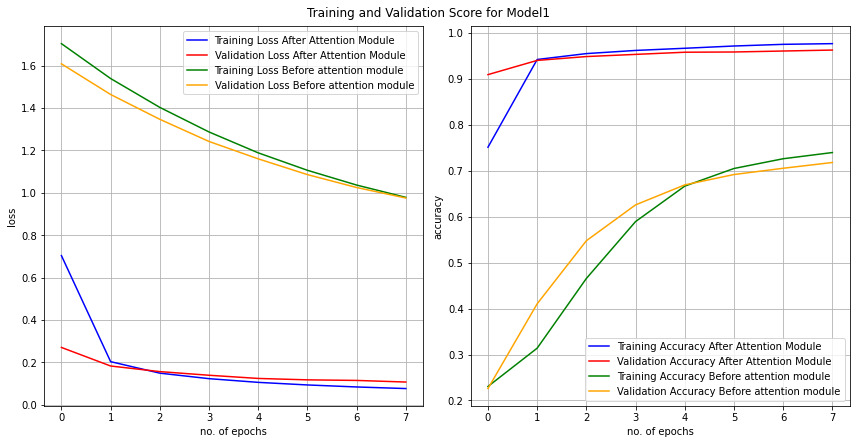

In [45]:
plot_score(history_1, name='Model1')

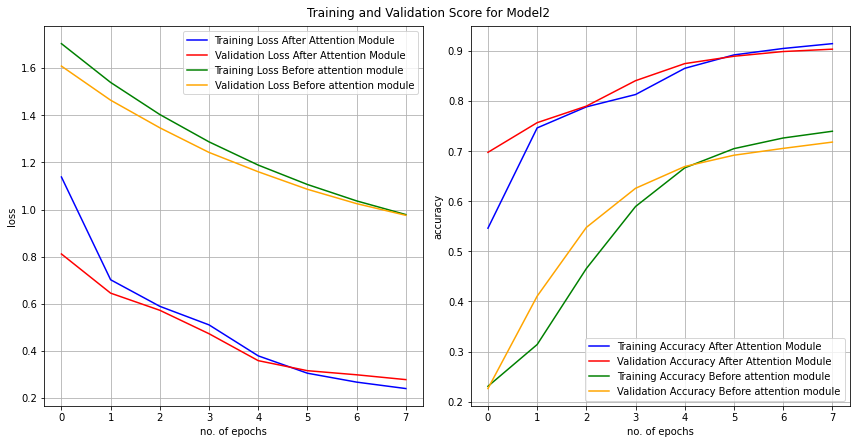

In [46]:
plot_score(history_2, name='Model2')

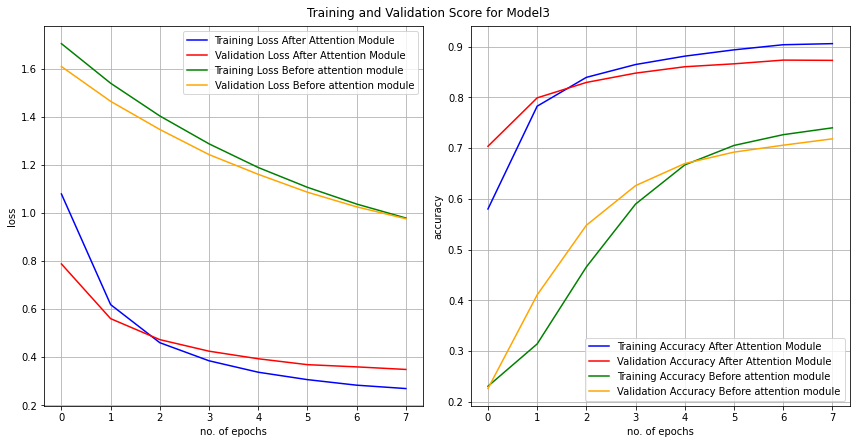

In [47]:
plot_score(history_3, name='Model3')

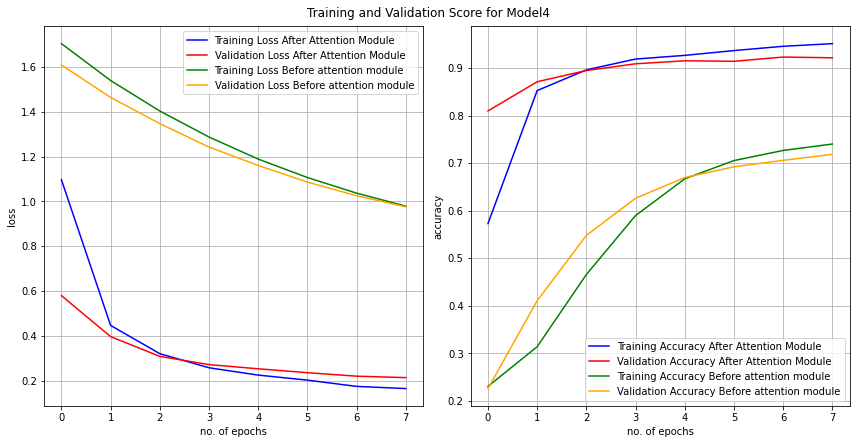

In [48]:
plot_score(history_4, name='Model4')

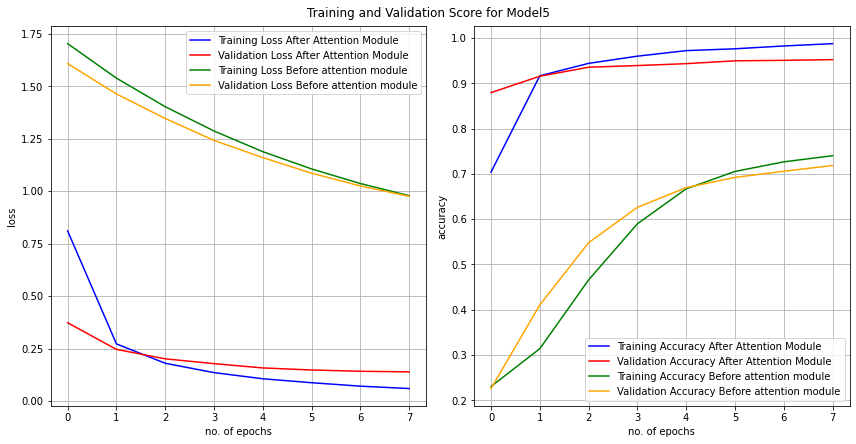

In [49]:
plot_score(history_5, name='Model5')

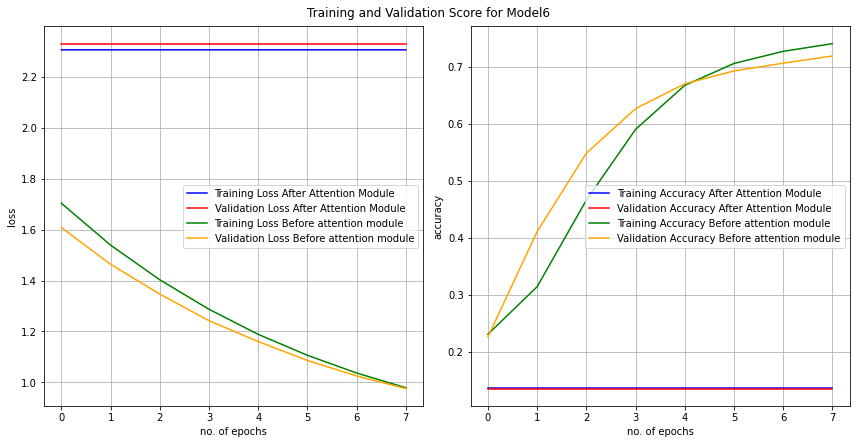

In [50]:
plot_score(history_6, name='Model6')

In [51]:
validation_data=(test_x, test_y)
train_data=(train_x, train_y)

In [52]:
def scores(models, x, y):
  loss = [] 
  accuracy = [] 
  for model in models:
    score = model.evaluate(x, y)
    loss.append(score[0])
    accuracy.append(score[1])

  model_type = ['without_attention_module','SENet_Between_input_and_Conv1-1','SENet_Between_pooling_and_Conv2-1',
                'SENet_Between_pooling_and_Conv3-1','SENet_Between_pooling_and_Conv4-1','SENet_Between_pooling_and_Conv5-1',
                'SENet_Between_pooling_and_Dense']
  # dictionary of lists 
  evaluate_dict = {'Models': model_type, 'model_loss': loss, 'model_accuracy': accuracy} 
    
  df = pd.DataFrame(evaluate_dict)
    
  return df

In [53]:
models = [model_0, model1, model2, model3, model4, model5, model6]
test_scores = scores(models, test_x, test_y)

60/60 [==============================] - 9s 149ms/step - loss: 2.3314 - accuracy: 0.1353


In [54]:
test_scores

,Models,model_loss,model_accuracy
0,without_attention_module,0.975698,0.718406
1,SENet_Between_input_and_Conv1-1,0.107778,0.963293
2,SENet_Between_pooling_and_Conv2-1,0.278890,0.904038
3,SENet_Between_pooling_and_Conv3-1,0.349160,0.873099
4,SENet_Between_pooling_and_Conv4-1,0.213782,0.921342
5,SENet_Between_pooling_and_Conv5-1,0.138756,0.952281
6,SENet_Between_pooling_and_Dense,2.331365,0.135291


In [55]:
train_scores = scores(models, train_x, train_y)

146/146 [==============================] - 22s 150ms/step - loss: 2.3070 - accuracy: 0.1366


In [57]:
train_scores

,Models,model_loss,model_accuracy
0,without_attention_module,0.952203,0.745443
1,SENet_Between_input_and_Conv1-1,0.070644,0.980270
2,SENet_Between_pooling_and_Conv2-1,0.221333,0.923011
3,SENet_Between_pooling_and_Conv3-1,0.256578,0.917221
4,SENet_Between_pooling_and_Conv4-1,0.147359,0.955179
5,SENet_Between_pooling_and_Conv5-1,0.049717,0.990993
6,SENet_Between_pooling_and_Dense,2.306997,0.136607


In [58]:
def get_index_output(model, name):
#     return Model(model.input, model.get_layer(name=name).output)
    return tf.keras.backend.function([model.input], [model.get_layer(name=name).output])

In [59]:
rand_list= random.sample(range(0, 1000), 10)

In [60]:
rand_list = random.sample(range(0, 1000), 10)

def visualize(modelx, layers, function=None, multi=True):
    rand_batch = test_x[rand_list]
    fig = plt.figure(figsize=(10,10))
    preds = get_index_output(modelx, layers)([rand_batch])[0]
    preds /= 255.
    for i in range(9):
        plt.subplot(3, 3, i+1)
        if multi:
            plt.imshow(preds[i,:,:, 1])
        else:
            plt.imshow(preds[i])
        plt.axis('off')
    plt.show()

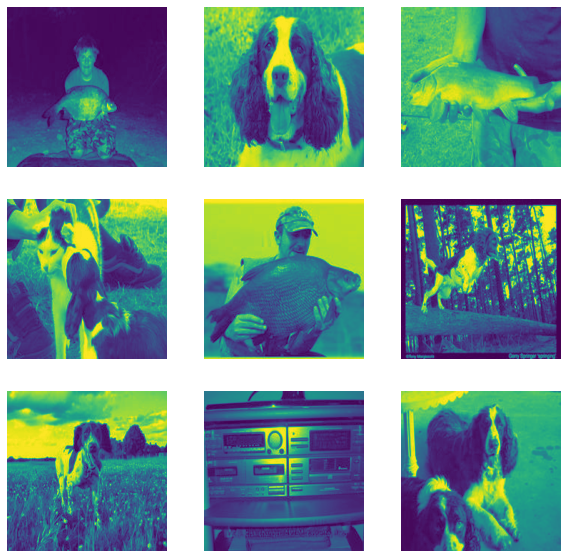

In [61]:
visualize(model1, 'SENet_multiply')

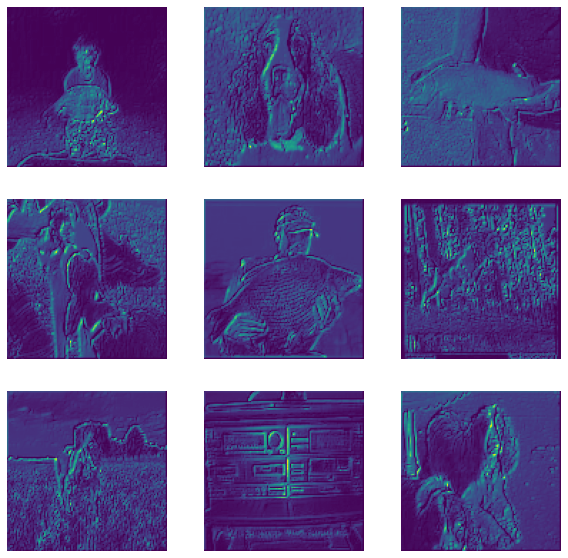

In [62]:
visualize(model2, 'SENet_multiply')

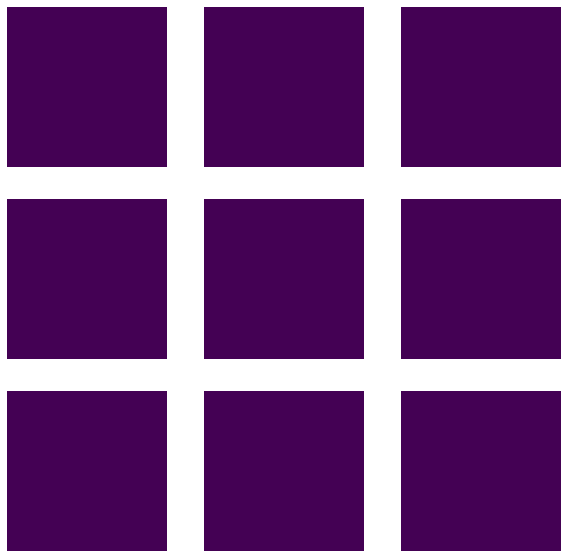

In [63]:
visualize(model3, 'SENet_multiply')

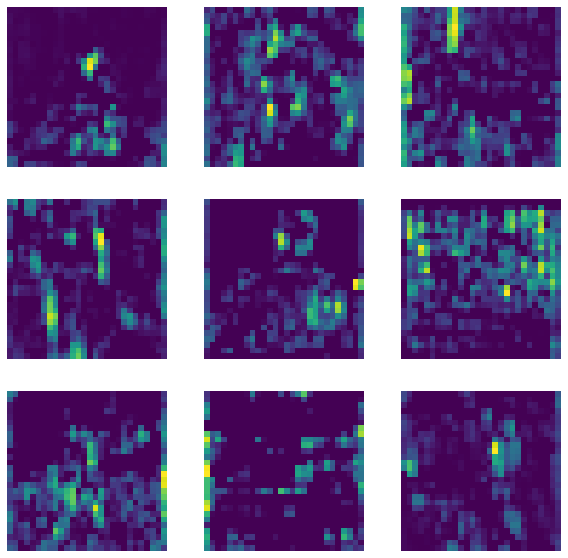

In [64]:
visualize(model4, 'SENet_multiply')

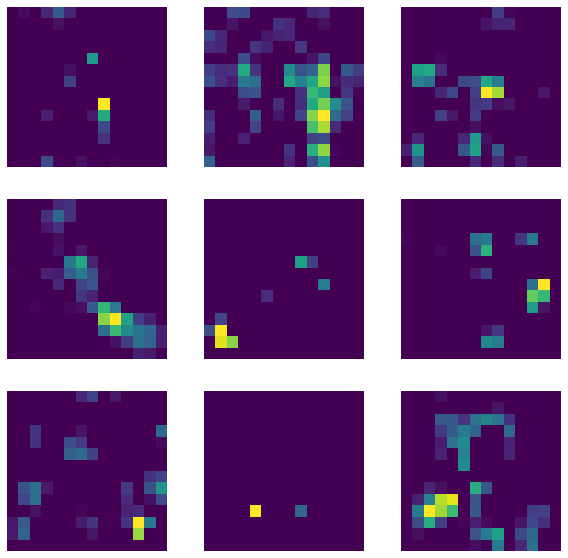

In [65]:
visualize(model5, 'SENet_multiply')

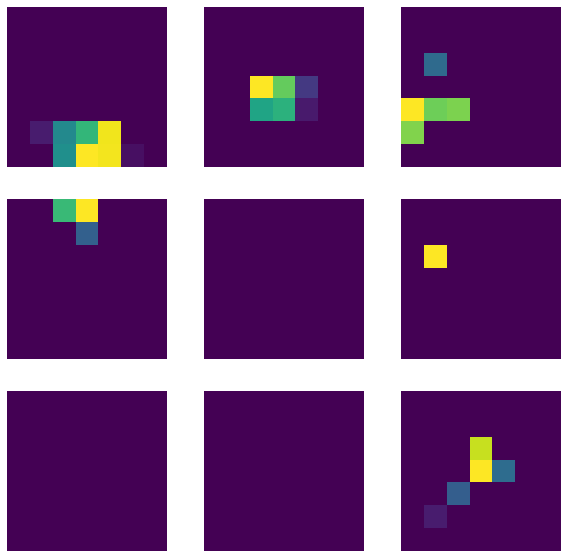

In [66]:
visualize(model6, 'SENet_multiply')